# Name : Mohammad Sabik Irbaz
# Student ID : 160041004
# Course : CSE 4836 - Pattern Recognition Lab
# Lab : 03
# Task : 02
# Topic : Building a Convolutional Neural Network model

In [83]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

bs = 16

In [84]:
import numpy as np
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

In [85]:
# Fetch data
train_data = datasets.CIFAR10('data',train=True,download=True,transform=transforms.ToTensor())
test_data = datasets.CIFAR10('data',train=False,download=True,transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


# Data Visualization

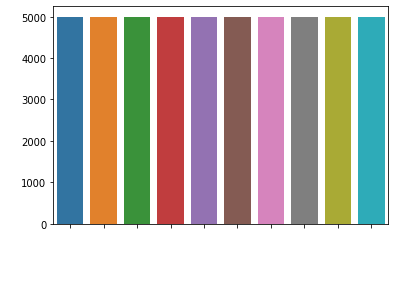

In [86]:
# Train Data Distribution
import seaborn as sns
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
labels = list()
for i in range(len(train_data)) : labels.append(train_data[i][1])
labels = torch.tensor(labels)
cnt = torch.bincount(labels).numpy()
ax = sns.barplot(x = class_names, y = cnt)
ax.set_xlabel('Class Names',color="white")
ax.set_ylabel('Train Data Distribution',color="white")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90,color="white");

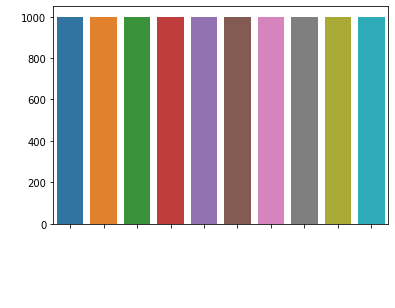

In [87]:
# Test Data Distribution
labels = list()
for i in range(len(test_data)) : labels.append(test_data[i][1])
labels = torch.tensor(labels)
cnt = torch.bincount(labels).numpy()
ax = sns.barplot(x = class_names, y = cnt)
ax.set_xlabel('Class Names',color="white")
ax.set_ylabel('Test Data Distribution',color="white")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90,color="white");

# Train - Test Load

In [88]:
train_loader = DataLoader(train_data, batch_size=bs)
test_loader = DataLoader(test_data, batch_size=bs)

# Model Architecture [ Intial ]

In [ ]:
''''
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
''''

In [134]:
class ConvNetClassifer1(nn.Module):
  def __init__(self):
    super().__init__()
    # Conv Layers
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.conv3 = nn.Conv2d(64, 64, 3)
    # Pooling Layers
    self.pool = nn.MaxPool2d(2,2)
    # FC Layers
    self.l1 = nn.Linear(64*4*4,64)
    self.l2 = nn.Linear(64,10)
  
  def forward(self, x):
    c1 = nn.functional.relu(self.conv1(x))
    c1 = self.pool(c1)
    c2 = nn.functional.relu(self.conv2(c1))
    c2 = self.pool(c2)
    c3 = nn.functional.relu(self.conv3(c2))
    c3 = c3.view(-1,64*4*4) # Flatten
    h1 = nn.functional.relu(self.l1(c3))
    logits = self.l2(h1)
    return logits

model1 = ConvNetClassifer1().cuda()

# Model Architecture [ Changed ]

Removed a conv layer and added a linear layer

In [133]:
class ConvNetClassifer2(nn.Module):
  def __init__(self):
    super().__init__()
    # Conv Layers
    self.conv1 = nn.Conv2d(3, 6, 5) # in_channel, out_channel, kernel_size
    self.conv2 = nn.Conv2d(6, 16, 5)
    # Pooling Layers
    self.pool = nn.MaxPool2d(2,2)
    # FC layers
    self.l1 = nn.Linear(16*5*5,120)
    self.l2 = nn.Linear(120,64)
    self.l3 = nn.Linear(64,10)
  
  def forward(self, x):
    c1 = nn.functional.relu(self.conv1(x))
    c1 = self.pool(c1)
    c2 = nn.functional.relu(self.conv2(c1))
    c2 = self.pool(c2)
    c2 = c2.view(-1, 16*5*5) # Flatten 
    h1 = nn.functional.relu(self.l1(c2))
    h2 = nn.functional.relu(self.l2(h1))
    logits = self.l3(h2)
    return logits

model2 = ConvNetClassifer2().cuda()

# Performance on Initial Model

In [109]:
optimizer = optim.Adam(model1.parameters(), lr = 1e-3)
loss = nn.CrossEntropyLoss()

In [110]:
model1

ConvNetClassifer1(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (l1): Linear(in_features=1024, out_features=64, bias=True)
  (l2): Linear(in_features=64, out_features=10, bias=True)
)

In [111]:
nb_epochs = 5

for epoch in range(nb_epochs):
  losses = list()
  model1.train()
  accuracies = list()
  for batch in train_loader:
    x,y = batch
    logit = model1(x.cuda())
    
    # Computing Loss
    J = loss(logit,y.cuda())

    # Cleaning the gradient
    model1.zero_grad()
    
    # Accumulating the partial derivatives of J wrt params
    J.backward()
    
    # Step in the opposite direction of the gradient
    optimizer.step()

    losses.append(J.item())
    accuracies.append(y.eq(logit.detach().argmax(dim=1).cpu()).float().mean())

  print(f'Epoch {epoch+1}',end=', ' )
  print(f'train loss: {torch.tensor(losses).mean():.2f}',end=', ')
  print(f'train accuracy: {torch.tensor(accuracies).mean():.2f}')
  
  # Evaluation

  losses = list()
  accuracies = list()
  model.eval()
  for batch in test_loader:
    x,y = batch
    
    # Forward prop to calculate loss
    with torch.no_grad():
      logit = model1(x.cuda())
    
    # Computing Loss
    J = loss(logit,y.cuda())

    losses.append(J.item())
    accuracies.append(y.eq(logit.detach().argmax(dim=1).cpu()).float().mean())
  print(f'Epoch {epoch+1}',end=', ' )
  print(f'test loss: {torch.tensor(losses).mean():.2f}',end=', ')
  print(f'test accuracy: {torch.tensor(accuracies).mean():.2f}')

Epoch 1, train loss: 1.53, train accuracy: 0.44
Epoch 1, test loss: 1.27, test accuracy: 0.54
Epoch 2, train loss: 1.17, train accuracy: 0.58
Epoch 2, test loss: 1.10, test accuracy: 0.61
Epoch 3, train loss: 1.01, train accuracy: 0.64
Epoch 3, test loss: 1.01, test accuracy: 0.65
Epoch 4, train loss: 0.91, train accuracy: 0.68
Epoch 4, test loss: 0.94, test accuracy: 0.68
Epoch 5, train loss: 0.84, train accuracy: 0.71
Epoch 5, test loss: 0.92, test accuracy: 0.69


# Performance on Changed Model

In [116]:
optimizer = optim.Adam(model2.parameters(), lr = 1e-3)
loss = nn.CrossEntropyLoss()

In [117]:
model2

ConvNetClassifer2(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (l1): Linear(in_features=400, out_features=120, bias=True)
  (l2): Linear(in_features=120, out_features=64, bias=True)
  (l3): Linear(in_features=64, out_features=10, bias=True)
)

In [118]:
nb_epochs = 5

for epoch in range(nb_epochs):
  losses = list()
  model2.train()
  accuracies = list()
  for batch in train_loader:
    x,y = batch
    logit = model2(x.cuda())
    
    # Computing Loss
    J = loss(logit,y.cuda())

    # Cleaning the gradient
    model2.zero_grad()
    
    # Accumulating the partial derivatives of J wrt params
    J.backward()
    
    # Step in the opposite direction of the gradient
    optimizer.step()

    losses.append(J.item())
    accuracies.append(y.eq(logit.detach().argmax(dim=1).cpu()).float().mean())

  print(f'Epoch {epoch+1}',end=', ' )
  print(f'train loss: {torch.tensor(losses).mean():.2f}',end=', ')
  print(f'train accuracy: {torch.tensor(accuracies).mean():.2f}')
  
  # Evaluation

  losses = list()
  accuracies = list()
  model2.eval()
  for batch in test_loader:
    x,y = batch
    
    # Forward prop to calculate loss
    with torch.no_grad():
      logit = model2(x.cuda())
    
    # Computing Loss
    J = loss(logit,y.cuda())

    losses.append(J.item())
    accuracies.append(y.eq(logit.detach().argmax(dim=1).cpu()).float().mean())
  print(f'Epoch {epoch+1}',end=', ' )
  print(f'test loss: {torch.tensor(losses).mean():.2f}',end=', ')
  print(f'test accuracy: {torch.tensor(accuracies).mean():.2f}')

Epoch 1, train loss: 1.66, train accuracy: 0.38
Epoch 1, test loss: 1.45, test accuracy: 0.47
Epoch 2, train loss: 1.39, train accuracy: 0.50
Epoch 2, test loss: 1.32, test accuracy: 0.52
Epoch 3, train loss: 1.28, train accuracy: 0.54
Epoch 3, test loss: 1.25, test accuracy: 0.55
Epoch 4, train loss: 1.20, train accuracy: 0.57
Epoch 4, test loss: 1.22, test accuracy: 0.57
Epoch 5, train loss: 1.14, train accuracy: 0.59
Epoch 5, test loss: 1.21, test accuracy: 0.57


# Train your initial model for 10,30,50,100 epochs. Plot the train-accuracy, test-accuracy in a graph and make comments on the performance of your model. 

In [135]:
optimizer = optim.Adam(model1.parameters(), lr = 1e-3)
loss = nn.CrossEntropyLoss()

In [136]:
nb_epochs = 100

epoch_list=[10,30,50,100]
train_acc=list()
test_acc=list()

for epoch in range(nb_epochs):
  losses = list()
  model1.train()
  accuracies = list()
  for batch in train_loader:
    x,y = batch
    
    # Forward propagation
    logit = model1(x.cuda())

    # Computing Loss
    J = loss(logit,y.cuda())

    # Cleaning the gradient
    model1.zero_grad()
    
    # Accumulating the partial derivatives of J wrt params
    J.backward()
    
    # Step in the opposite direction of the gradient
    optimizer.step()

    losses.append(J.item())
    accuracies.append(y.eq(logit.detach().argmax(dim=1).cpu()).float().mean())

  print(f'Epoch {epoch+1}',end=', ' )
  print(f'train loss: {torch.tensor(losses).mean():.2f}',end=', ')
  print(f'train accuracy: {torch.tensor(accuracies).mean():.2f}')


  if epoch+1 in epoch_list : 
    acc = torch.tensor(accuracies).mean()
    train_acc.append(acc.numpy())
  
  # Evaluation

  losses = list()
  accuracies = list()
  model1.eval()
  for batch in test_loader:
    x,y = batch
    
    # Forward prop to calculate loss
    with torch.no_grad():
      logit = model1(x.cuda())
    
    # Computing Loss
    J = loss(logit,y.cuda())

    losses.append(J.item())
    accuracies.append(y.eq(logit.detach().argmax(dim=1).cpu()).float().mean())
  print(f'Epoch {epoch+1}',end=', ' )
  print(f'test loss: {torch.tensor(losses).mean():.2f}',end=', ')
  print(f'test accuracy: {torch.tensor(accuracies).mean():.2f}')

  if epoch+1 in epoch_list : 
    acc = torch.tensor(accuracies).mean()
    test_acc.append(acc.numpy())

Epoch 1, train loss: 1.59, train accuracy: 0.41
Epoch 1, test loss: 1.31, test accuracy: 0.52
Epoch 2, train loss: 1.26, train accuracy: 0.55
Epoch 2, test loss: 1.19, test accuracy: 0.57
Epoch 3, train loss: 1.11, train accuracy: 0.61
Epoch 3, test loss: 1.07, test accuracy: 0.61
Epoch 4, train loss: 1.02, train accuracy: 0.64
Epoch 4, test loss: 1.04, test accuracy: 0.63
Epoch 5, train loss: 0.95, train accuracy: 0.66
Epoch 5, test loss: 1.02, test accuracy: 0.65
Epoch 6, train loss: 0.89, train accuracy: 0.69
Epoch 6, test loss: 0.99, test accuracy: 0.66
Epoch 7, train loss: 0.85, train accuracy: 0.70
Epoch 7, test loss: 0.97, test accuracy: 0.67
Epoch 8, train loss: 0.82, train accuracy: 0.72
Epoch 8, test loss: 0.96, test accuracy: 0.68
Epoch 9, train loss: 0.78, train accuracy: 0.73
Epoch 9, test loss: 0.96, test accuracy: 0.68
Epoch 10, train loss: 0.75, train accuracy: 0.73
Epoch 10, test loss: 0.97, test accuracy: 0.68
Epoch 11, train loss: 0.73, train accuracy: 0.74
Epoch 11,

In [137]:
train_acc,test_acc

([array(0.73458, dtype=float32),
  array(0.82434, dtype=float32),
  array(0.86182, dtype=float32),
  array(0.90336, dtype=float32)],
 [array(0.6753, dtype=float32),
  array(0.643, dtype=float32),
  array(0.638, dtype=float32),
  array(0.6426, dtype=float32)])

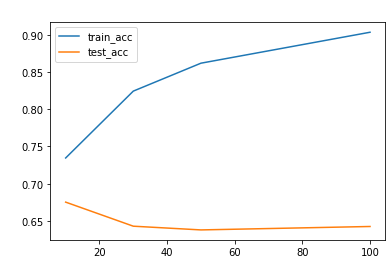

In [138]:
plt.plot(epoch_list, train_acc,label='train_acc')
plt.plot(epoch_list, test_acc,label='test_acc')
plt.title("Accuracy comparison on each epoch",color="white")
plt.xlabel("Epochs",color="white")
plt.ylabel("Accuracy",color="white")
plt.legend(loc="upper left")
plt.show()

# Confusion matrix for result up to 10 epochs

In [139]:
model1 = ConvNetClassifer1().cuda()
optimizer = optim.Adam(model1.parameters(), lr = 1e-3)
loss = nn.CrossEntropyLoss()

In [140]:
nb_epochs = 10

for epoch in range(nb_epochs):
  losses = list()
  model1.train()
  accuracies = list()
  for batch in train_loader:
    x,y = batch
    logit = model1(x.cuda())
    
    # Computing Loss
    J = loss(logit,y.cuda())

    # Cleaning the gradient
    model1.zero_grad()
    
    # Accumulating the partial derivatives of J wrt params
    J.backward()
    
    # Step in the opposite direction of the gradient
    optimizer.step()

    losses.append(J.item())
    accuracies.append(y.eq(logit.detach().argmax(dim=1).cpu()).float().mean())

  print(f'Epoch {epoch+1}',end=', ' )
  print(f'train loss: {torch.tensor(losses).mean():.2f}',end=', ')
  print(f'train accuracy: {torch.tensor(accuracies).mean():.2f}')
  
  # Evaluation

  losses = list()
  accuracies = list()
  model.eval()
  for batch in test_loader:
    x,y = batch
    
    # Forward prop to calculate loss
    with torch.no_grad():
      logit = model1(x.cuda())
    
    # Computing Loss
    J = loss(logit,y.cuda())

    losses.append(J.item())
    accuracies.append(y.eq(logit.detach().argmax(dim=1).cpu()).float().mean())
  print(f'Epoch {epoch+1}',end=', ' )
  print(f'test loss: {torch.tensor(losses).mean():.2f}',end=', ')
  print(f'test accuracy: {torch.tensor(accuracies).mean():.2f}')

Epoch 1, train loss: 1.63, train accuracy: 0.40
Epoch 1, test loss: 1.37, test accuracy: 0.49
Epoch 2, train loss: 1.28, train accuracy: 0.54
Epoch 2, test loss: 1.20, test accuracy: 0.57
Epoch 3, train loss: 1.15, train accuracy: 0.59
Epoch 3, test loss: 1.11, test accuracy: 0.60
Epoch 4, train loss: 1.06, train accuracy: 0.63
Epoch 4, test loss: 1.06, test accuracy: 0.62
Epoch 5, train loss: 0.99, train accuracy: 0.65
Epoch 5, test loss: 1.04, test accuracy: 0.63
Epoch 6, train loss: 0.94, train accuracy: 0.67
Epoch 6, test loss: 1.01, test accuracy: 0.64
Epoch 7, train loss: 0.90, train accuracy: 0.69
Epoch 7, test loss: 1.02, test accuracy: 0.65
Epoch 8, train loss: 0.86, train accuracy: 0.70
Epoch 8, test loss: 1.03, test accuracy: 0.64
Epoch 9, train loss: 0.83, train accuracy: 0.71
Epoch 9, test loss: 1.03, test accuracy: 0.65
Epoch 10, train loss: 0.80, train accuracy: 0.72
Epoch 10, test loss: 1.04, test accuracy: 0.65


# Predictions

In [143]:
model1.eval()
actual = list()
predicted = list()
for batch in test_loader:
    x,y = batch
    
    # Forward prop to calculate loss
    with torch.no_grad():
      logit = model1(x.cuda())
    
    preds = logit.detach().argmax(dim=1).cpu()
    for p in preds : predicted.append(p)

    actuals = y
    for a in actuals : actual.append(a)

actual = torch.tensor(actual)
predicted = torch.tensor(predicted)

# Confusion Matrix

Text(83.40000000000006, 0.5, 'True Label')

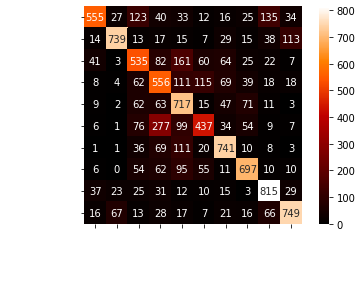

In [147]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(actual,predicted)
heat = sns.heatmap(mat,square=True,annot=True,fmt='d',cbar=True,cmap=plt.cm.gist_heat)
class_label = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
heat.set_xticklabels(class_label, rotation=90,color="white")
heat.set_yticklabels(class_label, rotation=0,color="white")
heat.set_xlabel('Predicted Label',color="white")
heat.set_ylabel('True Label',color="white")

In [148]:
class_acc = list()
for i in range(len(class_label)):
  pred = mat[i,i]
  act = np.sum(mat[i,:])
  class_acc.append(pred/act)
class_acc

[0.555, 0.739, 0.535, 0.556, 0.717, 0.437, 0.741, 0.697, 0.815, 0.749]

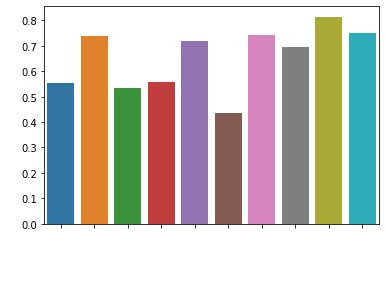

In [149]:
ax = sns.barplot(x = class_names, y = class_acc)
ax.set_xlabel('Type of Clothing',color="white")
ax.set_ylabel('Accuracy',color="white")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90,color="white");

# Easiet and hardest one for the model to classify

In [150]:
mxidx = np.argmax(class_acc)
print(f'Easiest class for the model to classify : {class_label[mxidx]}')

Easiest class for the model to classify : ship


In [151]:
mnidx = np.argmin(class_acc)
print(f'Hardest class for the model to classify : {class_label[mnidx]}')

Hardest class for the model to classify : dog
